# Feature Extraction and Classification on Guitarset

## Part 1: Feature Extraction
To classify guitar recordings of 5 different genres

***If running in Colab uncomment the following lines:***

In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

# #If not installed, install Essentia. 
# import importlib.util
# if importlib.util.find_spec('essentia') is None:
#     !pip install essentia

# !pip install mirdata
# !pip install pandas

In [54]:
# Standard libraries
import os

# Third-party libraries for data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

# Deep learning with Keras
from keras.models import Sequential
from keras import layers

# Imports for MIR
import mirdata
import essentia.standard as ess

## Data processing

Initialize the dataset with a specific local folder on drive and download the relevant elements, then load ids and tracks and visualize one

In [3]:
guitarset = mirdata.initialize("guitarset", data_home="data/raw/guitarset/")
guitarset.download(partial_download=['annotations', 'audio_mic']) # partially download data locally 
guitarset.validate

INFO: Downloading ['annotations', 'audio_mic'] to data/raw/guitarset/
INFO: [annotations] downloading annotation.zip
INFO: data/raw/guitarset/annotation/annotation.zip already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: [audio_mic] downloading audio_mono-mic.zip
INFO: data/raw/guitarset/audio_mono-mic/audio_mono-mic.zip already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.


<bound method Dataset.validate of The guitarset dataset
----------------------------------------------------------------------------------------------------


Call the .cite method for bibtex citations.
----------------------------------------------------------------------------------------------------


guitarset Track class

    Args:
        track_id (str): track id of the track

    Attributes:
        audio_hex_cln_path (str): path to the debleeded hex wave file
        audio_hex_path (str): path to the original hex wave file
        audio_mic_path (str): path to the mono wave via microphone
        audio_mix_path (str): path to the mono wave via downmixing hex pickup
        jams_path (str): path to the jams file
        mode (str): one of ['solo', 'comp']
            For each excerpt, players are asked to first play in 'comp' mode
            and later play a 'solo' version on top of the already recorded comp.
        player_id (str): ID of the different players.
            one

In [4]:
guitarset_ids = guitarset.track_ids  # Load IDs
guitarset_data = guitarset.load_tracks()  # Load data

print('number of elements in the dataset:',len(guitarset_ids))

guitarset_data[guitarset_ids[359]]  # Visualize a single track (the last one)

number of elements in the dataset: 360


Track(
  audio_hex_cln_path="data/raw/guitarset/audio_hex-pickup_debleeded/05_SS3-98-C_solo_hex_cln.wav",
  audio_hex_path="data/raw/guitarset/audio_hex-pickup_original/05_SS3-98-C_solo_hex.wav",
  audio_mic_path="data/raw/guitarset/audio_mono-mic/05_SS3-98-C_solo_mic.wav",
  audio_mix_path="data/raw/guitarset/audio_mono-pickup_mix/05_SS3-98-C_solo_mix.wav",
  jams_path="data/raw/guitarset/annotation/05_SS3-98-C_solo.jams",
  mode="solo",
  player_id="05",
  style="Singer-Songwriter",
  tempo=98.0,
  track_id="05_SS3-98-C_solo",
  audio_hex: Hexaphonic audio (6-channels) with one channel per string

        Returns,
  audio_hex_cln: Hexaphonic audio (6-channels) with one channel per string
           after bleed removal

        Returns,
  audio_mic: The track's audio

        Returns,
  audio_mix: Mixture audio (mono)

        Returns,
  beats: ,
  inferred_chords: ,
  key_mode: ,
  leadsheet_chords: ,
  multif0: ,
  notes: ,
  notes_all: ,
  pitch_contours: ,
)

Determine the number of different styles/genres to be used as classes 

In [5]:
# Get complete list of different genres in the dataset
style_names = []
for i in guitarset_ids:
    style_names.append(guitarset_data[i].style)
style_names = np.unique(style_names)

print(style_names)

['Bossa Nova' 'Funk' 'Jazz' 'Rock' 'Singer-Songwriter']


Create a dictionary with the styles/genres as keys

In [6]:
style_dict = {item: [] for item in style_names}
for i in guitarset_ids:
    style_dict[guitarset_data[i].style].append(guitarset_data[i].audio_mic_path)

style_dict['Rock'] # visualize all the entries in the Rock style

['data/raw/guitarset/audio_mono-mic/00_Rock1-130-A_comp_mic.wav',
 'data/raw/guitarset/audio_mono-mic/00_Rock1-130-A_solo_mic.wav',
 'data/raw/guitarset/audio_mono-mic/00_Rock1-90-C#_comp_mic.wav',
 'data/raw/guitarset/audio_mono-mic/00_Rock1-90-C#_solo_mic.wav',
 'data/raw/guitarset/audio_mono-mic/00_Rock2-142-D_comp_mic.wav',
 'data/raw/guitarset/audio_mono-mic/00_Rock2-142-D_solo_mic.wav',
 'data/raw/guitarset/audio_mono-mic/00_Rock2-85-F_comp_mic.wav',
 'data/raw/guitarset/audio_mono-mic/00_Rock2-85-F_solo_mic.wav',
 'data/raw/guitarset/audio_mono-mic/00_Rock3-117-Bb_comp_mic.wav',
 'data/raw/guitarset/audio_mono-mic/00_Rock3-117-Bb_solo_mic.wav',
 'data/raw/guitarset/audio_mono-mic/00_Rock3-148-C_comp_mic.wav',
 'data/raw/guitarset/audio_mono-mic/00_Rock3-148-C_solo_mic.wav',
 'data/raw/guitarset/audio_mono-mic/01_Rock1-130-A_comp_mic.wav',
 'data/raw/guitarset/audio_mono-mic/01_Rock1-130-A_solo_mic.wav',
 'data/raw/guitarset/audio_mono-mic/01_Rock1-90-C#_comp_mic.wav',
 'data/raw

Plotting one random sample per style

Plot waveforms of random samples of each stroke type...


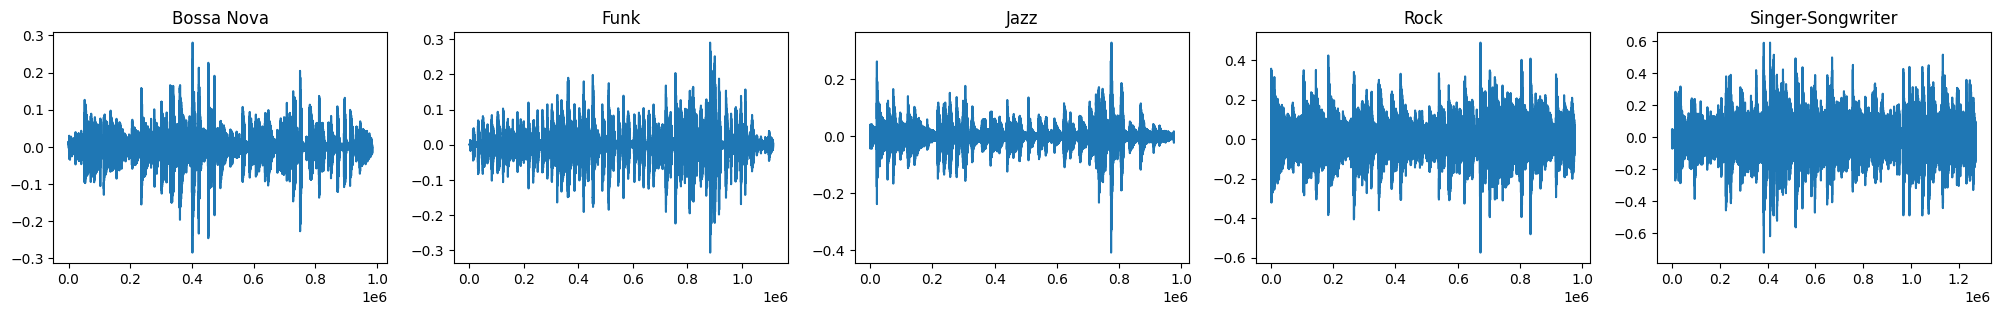

In [7]:
# Raw-data preprocess analysis parameters

_, fs = guitarset_data[guitarset_ids[0]].audio_mic

num_style = len(style_dict.keys())
print("Plot waveforms of random samples of each stroke type...")
plt.figure(1, figsize=(5 * num_style, 3))
file_ind_inlist = 0 # 0: let's take the first file in the list for sample plots
for i, style in enumerate(style_dict.keys()):
    sample_file = style_dict[style][file_ind_inlist]
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
    
    plt.subplot(1,num_style,(i+1))
    plt.plot(x)
    plt.title(style)

## Preprocessing of raw data: Segmentation, splitting, alignment,... 

The `split_file()` function is left here only for further testing purposes, but it's not really used since it's not required for this task.

In [8]:
# creating a local sample_data folder with bash
! mkdir /content/drive/MyDrive/MIR/guitarset/sample_data

mkdir: /content/drive/MyDrive/MIR/guitarset: No such file or directory


In [9]:
# Raw-data preprocess analysis parameters
windowSize = 1024
hopSize = 512
NRG_threshold_ratio = 0.00 #threshold expressed as ratio with respect to the maximum value
#Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}

In [10]:
#Function definition
def split_file(filename, params):
    '''Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()
    NRG = [];
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)
    
    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > NRG_threshold_ratio] = 1
    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)
    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize
    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize
    return (x, NRG, split_decision_func, start_indexes, stop_indexes)

Sample plots for waveform versus energy and splits based on energy threshold


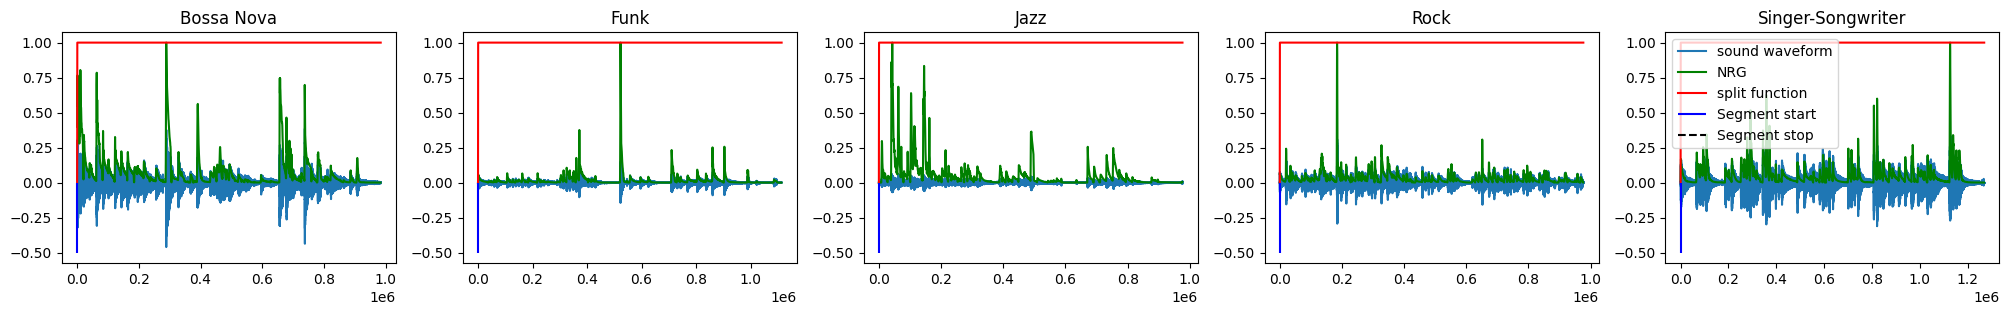

In [11]:
num_style = len(style_names)
print("Sample plots for waveform versus energy and splits based on energy threshold")

file_indexes = [1]
for file_ind_inlist in file_indexes:
    plt.figure(file_ind_inlist, figsize=(5 * num_style, 3))
    for i, style in enumerate(style_dict.keys()):
        sample_file = style_dict[style][file_ind_inlist]
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        #Plotting functions for checking the split decisions
        plt.subplot(1,num_style,(i+1))
        plt.title(style)
        plt.plot(x, label = 'sound waveform')
        plt.plot(np.arange(NRG.size) * hopSize, NRG, 'g', label = 'NRG')
        plt.plot(np.arange(split_decision_func.size) * hopSize, split_decision_func,'r', label = 'split function')
        plt.vlines(start_indexes, ymin = -0.5, ymax = 0, colors='b', linestyles='solid', label='Segment start')
        plt.vlines(stop_indexes, ymin = -0.5, ymax = 0, colors='k', linestyles='dashed', label='Segment stop')

plt.legend(loc="best");


Splitting file is not necessary for this task

In [12]:
# main_data_dir = 'sample_data'
# if not os.path.exists(main_data_dir): #creating the directory
#     os.mkdir(main_data_dir)
# segments_dir = os.path.join(main_data_dir,'segments')
# if not os.path.exists(segments_dir): #creating the directory
#     os.mkdir(segments_dir)

# segment_files = []
# for style, files in style_dict.items():
#     for sample_file in files:
#         #Get file id
#         stroke_id =  sample_file.split('__')[-1].split('.')[0]
#         x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
#         (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
#         #Croping segments
#         for start, stop in zip(start_indexes, stop_indexes):
#             x_seg = x[start: stop]
#             #Final check for amplitude (to avoid silent segments selection due to noise in split function)
#             if(np.max(np.abs(x_seg)) > 0.05):
#                 #Amplitude normalisation
#                 x_seg = x_seg / np.max(np.abs(x_seg))
#                 filename = os.path.join(segments_dir, stroke_id + '.wav')
#                 ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(x_seg)
#                 segment_files.append(filename)

# print(len(segment_files),'segment files created')

In [13]:
#If required, you can use this cell to delete all files in a given folder

def delete_files_in_dir(dir_name):
    '''Deleting all files in a directory
    '''
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            file_name = os.path.join(root,file)
            os.remove(file_name);print(file_name, 'removed');

# delete_files_in_dir('/content/sample_data')

## Feature extraction 

Compute a list of common low-level features for each of the files and form a data frame including features and categories. Using the [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html) that would compute a large number of features commonly used in MIR literature. 

In [16]:
# Print descriptors to be considered
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(guitarset_data["03_Rock2-142-D_comp"].audio_mic_path)

scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done


Running Essentia MusicExtractor for all files, keeping a subset of features, writing to an output file: data.csv.

**The use of 'style' has been replaced by 'genre' to avoid confusion later in the classification**

In [17]:
import csv

# Extracting features and writing in data.csv file in the segments folder
#  each line in the data.csv file represents a sample with features and the class information as the last element

data_file = 'data/processed/data.csv'
file_count = 0
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['genre']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for style, files in style_dict.items():
        for sample_file in files:
          file_count +=1
          if file_count % 20 == 0: #print name of a file every 20 files
              print(file_count, "files processed, current file: ", sample_file)

          #Compute and write features for file
          features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                        lowlevelFrameSize = 2048,
                                                        lowlevelHopSize = 1024,
                                                        lowlevelStats = ['mean', 'stdev'])(sample_file)
          selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
          label = sample_file.split('/')[-1].split('.')[0].split('-')[0].split('_')[-1]
          unified_label = label[:-1]
          line2write = str(selected_features)[1:-1] + ',' + unified_label + '\n'
          writer.write(line2write)
print("A total of ", file_count, "files processed")

[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, a

20 files processed, current file:  data/raw/guitarset/audio_mono-mic/01_BN2-166-Ab_solo_mic.wav


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, a

40 files processed, current file:  data/raw/guitarset/audio_mono-mic/03_BN1-147-Gb_solo_mic.wav


[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtra

60 files processed, current file:  data/raw/guitarset/audio_mono-mic/04_BN3-154-E_solo_mic.wav


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, a

80 files processed, current file:  data/raw/guitarset/audio_mono-mic/00_Funk2-119-G_solo_mic.wav


[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtra

100 files processed, current file:  data/raw/guitarset/audio_mono-mic/02_Funk1-97-C_solo_mic.wav


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, a

120 files processed, current file:  data/raw/guitarset/audio_mono-mic/03_Funk3-98-A_solo_mic.wav


[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtra

140 files processed, current file:  data/raw/guitarset/audio_mono-mic/05_Funk2-119-G_solo_mic.wav


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, a

160 files processed, current file:  data/raw/guitarset/audio_mono-mic/01_Jazz1-200-B_solo_mic.wav


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, a

180 files processed, current file:  data/raw/guitarset/audio_mono-mic/02_Jazz3-150-C_solo_mic.wav


[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtra

200 files processed, current file:  data/raw/guitarset/audio_mono-mic/04_Jazz2-187-F#_solo_mic.wav


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, a

220 files processed, current file:  data/raw/guitarset/audio_mono-mic/00_Rock1-90-C#_solo_mic.wav


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, a

240 files processed, current file:  data/raw/guitarset/audio_mono-mic/01_Rock3-148-C_solo_mic.wav


[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtra

260 files processed, current file:  data/raw/guitarset/audio_mono-mic/03_Rock2-85-F_solo_mic.wav


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, a

280 files processed, current file:  data/raw/guitarset/audio_mono-mic/05_Rock1-90-C#_solo_mic.wav


[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtra

300 files processed, current file:  data/raw/guitarset/audio_mono-mic/00_SS3-98-C_solo_mic.wav


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, a

320 files processed, current file:  data/raw/guitarset/audio_mono-mic/02_SS2-88-F_solo_mic.wav


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, a

340 files processed, current file:  data/raw/guitarset/audio_mono-mic/04_SS1-68-E_solo_mic.wav


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, a

360 files processed, current file:  data/raw/guitarset/audio_mono-mic/05_SS3-98-C_solo_mic.wav
A total of  360 files processed


[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done


In [18]:
#Read data with pandas module
data = pd.read_csv(data_file)

#Plot first lines of our data
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,genre
0,0.678595,17.053656,5.359172,0.323045,0.095043,44.568661,109.956322,2.969123,3.602786,4.651040,...,354.715088,3.788055,1.843490,2912615.25,1574234.125,0.773643,0.731553,0.017444,0.012978,BN
1,0.498945,15.277541,5.771532,0.255574,0.087297,11.360999,19.550810,2.116331,1.717938,9.209044,...,599.172485,3.197023,1.859064,2894352.50,1406329.625,0.958381,1.027366,0.031643,0.022105,BN
2,0.958746,13.777791,4.144764,0.280946,0.093710,29.206333,86.143341,2.965204,2.741709,5.926824,...,378.314056,3.303910,1.900116,3341306.75,1554873.125,0.635393,0.641100,0.019124,0.014579,BN
3,0.908284,14.065393,3.930786,0.261140,0.074184,10.322021,15.642951,2.402953,1.101622,7.842619,...,408.312958,3.308774,1.574727,2523976.75,1350682.000,0.797930,0.542715,0.020422,0.009778,BN
4,0.689578,15.046312,5.136526,0.257579,0.086898,42.263268,150.816269,3.522104,3.901124,7.926633,...,649.332947,2.534679,1.302398,3900090.00,1733229.375,0.704390,0.891672,0.024933,0.018857,BN


/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


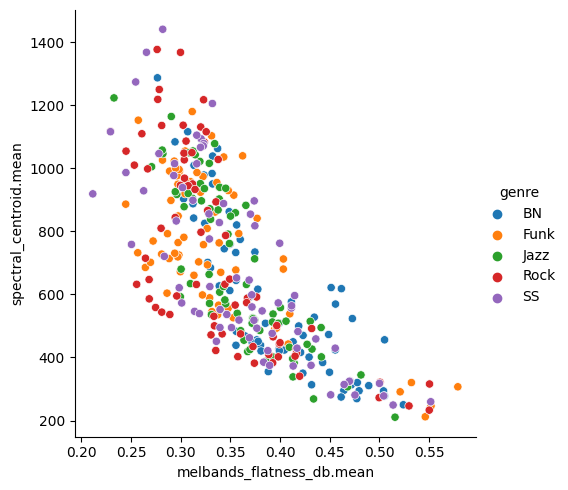

In [19]:
# Take two random features and plot the sample points
sns.relplot(x = "melbands_flatness_db.mean", y = "spectral_centroid.mean", hue = "genre", data = data);

### Preprocessing of the features


In [20]:
data_modif = data.copy()

#Let's use sklearn's preprocessing tools for applying normalisation to features

min_max_scaler = preprocessing.MinMaxScaler()
data_modif.iloc[:,:84] = min_max_scaler.fit_transform(data.iloc[:,:84].values)

In [21]:
# Checking if our data is balanced (if not, we should balance it to prevent our model to be baised)
data_modif.genre.value_counts()

genre
BN      72
Funk    72
Jazz    72
Rock    72
SS      72
Name: count, dtype: int64

## Supervised learning approach (Support Vector Machines)

In [22]:
# Input values put in a matrix, there are 84 features
X = data_modif.iloc[:,:84].values 
# Creating output values
data_modif.genre = pd.Categorical(data_modif.genre)  # convert to categorical data
y = np.array(data_modif.genre.cat.codes)  # create label encoded outputs
# Print the first sample
print("Features of the first sample: ", X[0])
print("Class of the first sample: ", y[0])

Features of the first sample:  [0.69183184 0.64224497 0.64433697 0.58412364 0.43103037 0.20001124
 0.15140456 0.30579205 0.32247983 0.19163271 0.37308762 0.55433891
 0.41004975 0.17391654 0.74677351 0.65972951 0.54793186 0.48319055
 0.71745548 0.57491031 0.82094807 0.814469   0.34824793 0.57653891
 0.11431473 0.04396984 0.46411878 0.42112137 0.47471967 0.1558894
 0.4681786  0.25458869 0.63309736 0.56216269 0.56925508 0.44682925
 0.16259599 0.01729041 0.42854387 0.16429035 0.13356592 0.24898635
 0.45050723 0.53862853 0.91922105 0.28591214 0.71024618 0.55518977
 0.36734693 0.87910579 0.16708057 0.28302283 0.16021525 0.27492028
 0.67416469 0.33166452 0.30956003 0.30956364 0.06157792 0.03450062
 0.12518326 0.21721484 0.03945818 0.03766526 0.50525406 0.36876589
 0.31060106 0.55965869 0.37941944 0.39383427 0.17736639 0.14475814
 0.44429368 0.4452839  0.09677461 0.1856304  0.30243326 0.28025135
 0.48542724 0.40402315 0.29671734 0.19747034 0.17516902 0.23635494]
Class of the first sample:  0


In [23]:
# Let's split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Check sizes of input and output vectors
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

Size of train features matrix:  (241, 84) , Size of train output vector:  (241,)
Size of test features matrix:  (119, 84) , Size of test output vector:  (119,)


In [24]:
# Define and train the model
clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))

# Fit model with training data
clf.fit(X_train, y_train)

# Predict classes of test samples
y_pred = clf.predict(X_test)

In [25]:
# Test the model
# Let's check for each sample in the test set if prediction matches the true class information
y_test == y_pred

array([ True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True, False, False,  True,  True,  True, False,
        True, False,  True,  True, False,  True, False,  True, False,
       False,  True, False, False, False, False, False,  True, False,
        True, False,  True,  True,  True, False, False, False, False,
        True, False, False, False,  True,  True,  True, False, False,
       False, False, False,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False,  True, False, False,  True, False,
        True, False,  True, False,  True, False, False, False,  True,
        True, False, False,  True,  True, False,  True, False,  True,
       False,  True, False, False, False, False, False, False,  True,
       False,  True])

In [26]:
# Data is balanced, so you can use accuracy as a measure:
print("accuracy: ", np.sum(y_test == y_pred)/len(y_test))

accuracy:  0.453781512605042


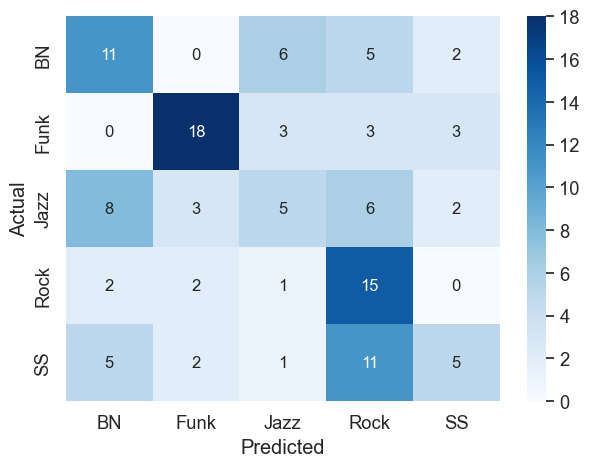

In [27]:
# Print the confusion matrix

classes = np.unique(data_modif.genre)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

## Supervised learning approach (Neural Network)

In [28]:
# Let's start by splitting our data 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

# ..and apply normalisation
scaler = StandardScaler().fit(X_train_val)
norm_x_train_val = scaler.transform(X_train_val)
norm_x_test = scaler.transform(X_test)

In [29]:
onehot_encoder = OneHotEncoder(sparse=False)
y_train_val_onehot = onehot_encoder.fit_transform(y_train_val.reshape(len(y_train_val), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))
print("One-hot encoded y_train_val shape = ", y_train_val_onehot.shape)
print("One-hot encoded y_test shape = ", y_test_onehot.shape)

One-hot encoded y_train_val shape =  (288, 5)
One-hot encoded y_test shape =  (72, 5)


/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [30]:
def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 40))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.3))

    # 2. hidden layer
    model.add(layers.Dense(name='HiddenLayer_2', units = 20))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 5))
    model.add(layers.Activation('sigmoid'))
    
    return model

model = compose_model(X_train_val.shape[1])

In [31]:
model.summary()  # Plot summary of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (BatchNormaliza  (None, 84)                336       
 tion)                                                           
                                                                 
 HiddenLayer_1 (Dense)       (None, 40)                3400      
                                                                 
 batch_normalization (Batch  (None, 40)                160       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 40)                0         
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 HiddenLayer_2 (Dense)       (None, 20)                8

In [32]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
summary = model.fit(X_train_val, y_train_val_onehot, batch_size = 50, epochs = 250, validation_split=0.2, verbose=0)

In [33]:
score = model.evaluate(X_test, y_test_onehot, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.46787697076797485
Test accuracy: 0.4583333432674408


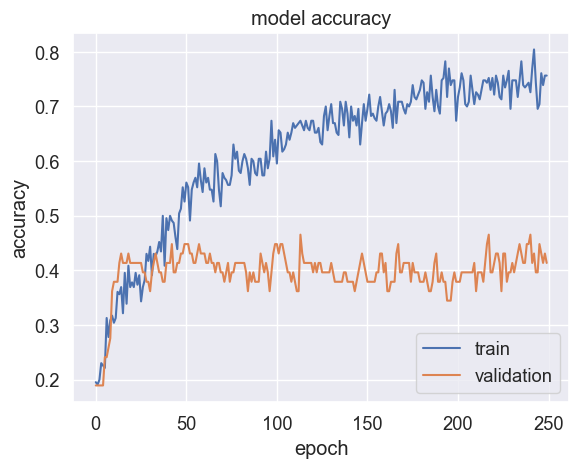

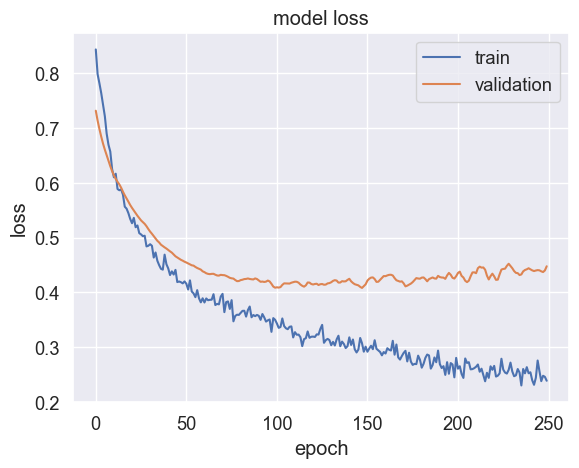

In [34]:
# summarize history for accuracy
plt.plot(summary.history['accuracy'])
plt.plot(summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Part 2: Sound classification

In [35]:
%pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


In [36]:
RNG_STATE = 0

# Train test splitting using sklearn
X_train, X_test, y_train_text, y_test_text = train_test_split(data[data.columns[:-1]],data[data.columns[-1]], test_size=0.2, random_state=RNG_STATE)

In [37]:
# We'll need to use a label encoder to encode our instrument
# names as numeric identifiers (0, 1, 2, ..., 9)
encoder = LabelEncoder()

# "Fit" on the training labels; this is really just specifying our vocabulary
# transform maps the encoding over the list of strings to give our encoded label array
y_train = encoder.fit_transform(y_train_text)

# Since the encoder is already fit, we can now transform our test set labels as well
y_test = encoder.transform(y_test_text)

              precision    recall  f1-score   support

          BN       0.47      0.53      0.50        17
        Funk       0.62      0.76      0.68        17
        Jazz       0.50      0.23      0.32        13
        Rock       0.50      0.35      0.41        17
          SS       0.21      0.38      0.27         8

    accuracy                           0.47        72
   macro avg       0.46      0.45      0.44        72
weighted avg       0.49      0.47      0.46        72



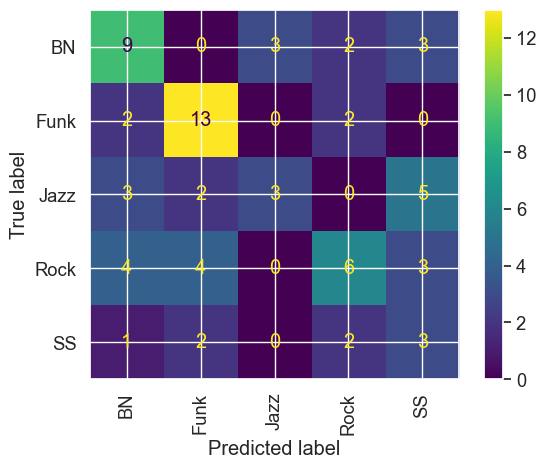

In [49]:
# Your classifier and training process
clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))
clf.fit(X_train, y=y_train)
y_pred = clf.predict(X_test)

# Classification report
report = classification_report(y_test, y_pred, target_names=encoder.classes_)
print(report)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(xticks_rotation='vertical')


## Feature visualization

In [50]:
### How to visualize features using metric learning https://github.com/bmcfee/ismir2020-metric-learning
# scikit-learn provides Linear discriminant analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Finally, umap will let us map high-dimensional data down to 2-d for plotting
import umap

/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/francescopapaleo/.pyenv/versions/3.11.4

We visualize the data by applying a transformation using UMAP from a high dimensional space to a low dimensional space. Similarly to the PCA reduction, the output axes do not hold any specific meaning.

In [51]:
reducer = umap.UMAP(random_state=RNG_STATE)

# We'll apply all but the last stage (KNN classifier) of our pipeline to the data.
# In this case, we just have one previous stage, which does feature normalization.
# This will change in subsequent examples.

X_train_transformed = clf[:-1].transform(X_train)
X_test_transformed = clf[:-1].transform(X_test)

# Fit on the transformed data, and then transform the test data
embed = reducer.fit_transform(X_train_transformed)
embed_test = reducer.transform(X_test_transformed)

In the plot the different classes are plotted with different colors, while the train and test datasets are denoted by x or circles.
If the test and training data of the same color appear near each other in the visualization, then nearest neighbor classification should work well.

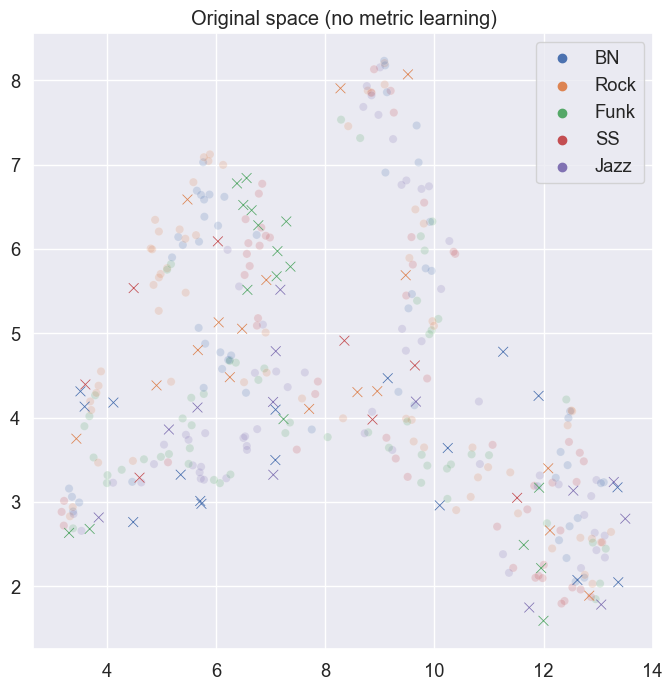

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=y_train_text, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=y_test_text, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Original space (no metric learning)');

## Linear projection of features
We use Linear Discriminant Analysis to better separate the classes by learning a 5-dimensional projection of the features. 

              precision    recall  f1-score   support

          BN       0.64      0.53      0.58        17
        Funk       0.79      0.88      0.83        17
        Jazz       0.38      0.38      0.38        13
        Rock       0.50      0.47      0.48        17
          SS       0.20      0.25      0.22         8

    accuracy                           0.54        72
   macro avg       0.50      0.50      0.50        72
weighted avg       0.55      0.54      0.54        72



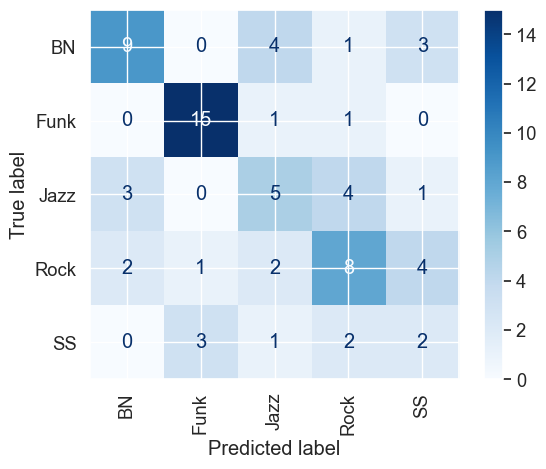

In [57]:
# Define the classifier pipeline
clf = make_pipeline(
    StandardScaler(), 
    LinearDiscriminantAnalysis(), 
    KNeighborsClassifier(n_neighbors=1)
)
clf.fit(X_train, y=y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Generate and print a classification report
report = classification_report(y_test, y_pred, target_names=encoder.classes_)
print(report)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()


Let's visualize the results: 

In [58]:
reducer = umap.UMAP(random_state=RNG_STATE)

# We'll fit the umap embedding on the data after applying our learned transformation
embed = reducer.fit_transform(clf[:-1].transform(X_train))
embed_test = reducer.transform(clf[:-1].transform(X_test))

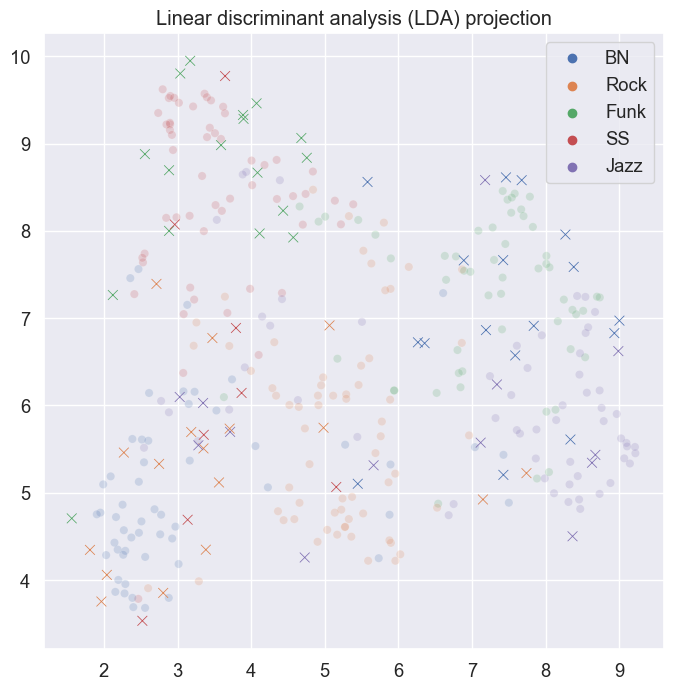

In [59]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=y_train_text, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=y_test_text, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Linear discriminant analysis (LDA) projection');

The projection learned by LDA tells us the weight assigned to each of the training features. 

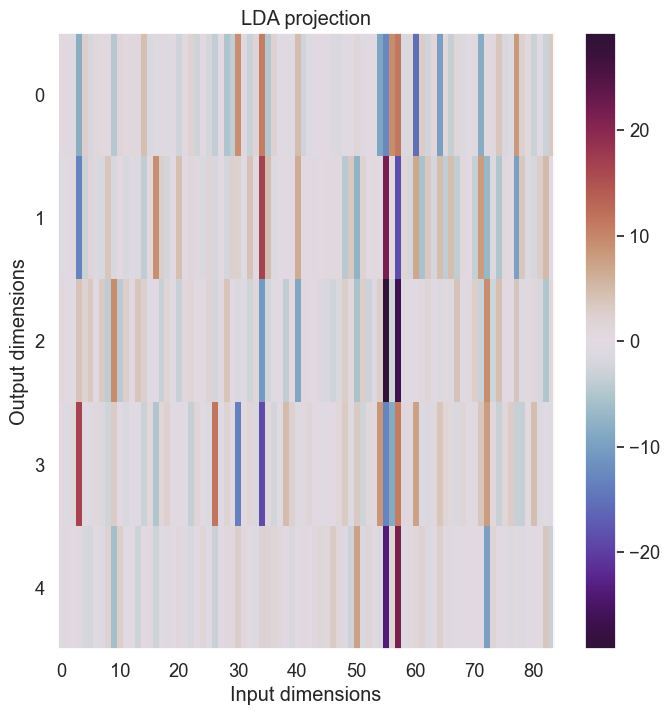

In [60]:
fig, ax = plt.subplots(figsize=(8, 8))
model = clf.steps[1][1]
weights = model.coef_

img = ax.imshow(weights, cmap='twilight_shifted', vmin=-np.abs(weights).max(), vmax=np.abs(weights).max(), aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax)
ax.grid(False)
ax.set(xlabel='Input dimensions', ylabel='Output dimensions', title='LDA projection');

Which features are given more importance?

Select and print the single most important feature:

In [61]:
highest_weight = np.max(weights)
for i in range(len(weights)):
  if (weights[i] == highest_weight).any():
    print(data.columns[:-1][i])

barkbands_crest.stdev


Select and print the 5 most important features:

In [62]:
sorted_indices = np.argsort(-np.array(weights))

for i in range(len(sorted_indices)):
  print(data.columns[:-1][i])

average_loudness
barkbands_crest.mean
barkbands_crest.stdev
barkbands_flatness_db.mean
barkbands_flatness_db.stdev
